In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#import MiniPole code

#classes to create synthetic data, not needed if you have your data available
from mini_pole import GreenFunc
from mini_pole.spectrum_example import *

#class to perform continuation
from mini_pole import MiniPole

In [3]:
#tools for calculating the Green's function from the corresponding poles
def cal_G_scalar(z, Al, xl):
    G_z = 0.0
    for i in range(xl.size):
        G_z += Al[i] / (z - xl[i])
    return G_z

def cal_G_vector(z, Al, xl):
    G_z = 0.0
    for i in range(xl.size):
        G_z += Al[[i]] / (z.reshape(-1, 1) - xl[i])
    return G_z

# 1. Obtain synthetic data for the input

In [4]:
beta = 100 #inverse temperature
n_w = 500  #number of non-negative Matsubara points
n_orb = 2  #number of orbitals

In [5]:
#A_x is the expression of the spectral function
A_f_diag = lambda x: 0.25 * gaussian(x, mu=-1.5, sigma=0.5) + 0.5 * gaussian(x, mu=0, sigma=0.5) + 0.25 * gaussian(x, mu=1.5, sigma=0.5)
A_f_offdiag = lambda x: -0.2 * gaussian(x, mu=-1, sigma=0.6) + 0.2 * gaussian(x, mu=1, sigma=0.6)
gf_f1 = GreenFunc("F", beta, "continuous", A_x=A_f_diag   , x_min=-np.inf, x_max=np.inf)
gf_f2 = GreenFunc("F", beta, "continuous", A_x=A_f_offdiag, x_min=-np.inf, x_max=np.inf)

#obtain Matsubara data from numerical integration for the first n_w non-negative frequencies
gf_f1.get_matsubara(n_w)
gf_f2.get_matsubara(n_w)
#G_w: Matsubara data; w: corresponding Matsubara frequencies
w = gf_f1.w
G_w = np.zeros((w.size, n_orb, n_orb), dtype=np.complex_)
for i in range(n_orb):
    for j in range(n_orb):
        if i == j:
            G_w[:, i, j] = gf_f1.G_w
        else:
            G_w[:, i, j] = gf_f2.G_w

# 2. Perform MiniPole analytic continuation

In [6]:
#MiniPole for matrix-valued Green's function
#err: error tolerance. Should be set to no less than the noise level
p = MiniPole(G_w, w, err=1.e-10)

# 3. Plot results

In [7]:
# Analytic continuation results are stored in p.pole_weight (for pole weights) and p.pole_location (for pole locations)
x = np.linspace(-5, 5, 1000)
G_f_r = cal_G_vector(x, p.pole_weight.reshape(-1, n_orb ** 2), p.pole_location).reshape(-1, n_orb, n_orb)

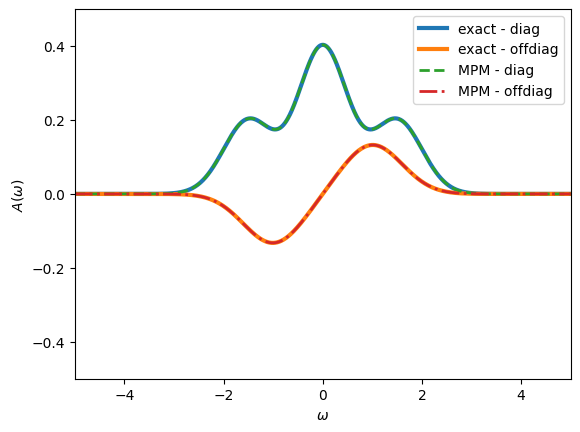

In [8]:
plt.plot(x, A_f_diag(x), linewidth=3, label="exact - diag")
plt.plot(x, A_f_offdiag(x), linewidth=3, label="exact - offdiag")
plt.plot(x, -1.0 / np.pi * G_f_r[:, 0, 0].imag, "--", linewidth=2, label="MPM - diag")
plt.plot(x, -1.0 / np.pi * G_f_r[:, 0, 1].imag, "-.", linewidth=2, label="MPM - offdiag")
plt.legend()
plt.xlim([-5, 5])
plt.ylim([-0.5, 0.5])
plt.xlabel(r"$\omega$")
plt.ylabel(r"$A(\omega)$")
plt.show()

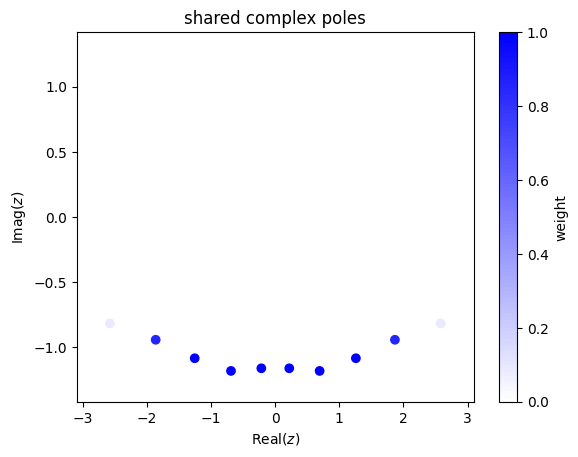

In [9]:
from matplotlib.colors import LinearSegmentedColormap
colors = [(1, 1, 1), (0, 0, 1)] #(R, G, B) tuples for white and blue
n_bins = 100 #Discretize the interpolation into bins
cmap_name = "WtBu"
cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins) #Create the colormap

pts = p.pole_location
scatter = plt.scatter(pts.real, pts.imag, c=np.linalg.norm(p.pole_weight.reshape(-1, p.n_orb ** 2), axis=1), vmin=0, vmax=1, cmap=cmap)
cbar = plt.colorbar(scatter)
cbar.set_label('weight')
x_max = np.abs(p.pole_location.real).max() * 1.2
y_max = max(np.abs(p.pole_location.imag).max() * 1.2, 1.0)
plt.xlim([-x_max, x_max])
plt.ylim([-y_max, y_max])
plt.xlabel(r"Real($z$)")
plt.ylabel(r"Imag($z$)")
plt.title("shared complex poles")
plt.show()